In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.utils import resample
from scipy.stats import loguniform
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, brier_score_loss

df = pd.read_csv('cardio_data_cleaned(IQR).csv')

In [2]:
df.isna().sum()

age            0
gender         0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
BMI            0
MAP            0
dtype: int64

In [66]:
features = ['age', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'BMI', 'MAP']
X = df[features]
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
X_test.iloc[15]

age            5
gender         2
cholesterol    3
gluc           1
smoke          0
alco           0
active         1
BMI            3
MAP            5
Name: 20589, dtype: int64

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

SVM

In [9]:
X_train_sub, y_train_sub = resample(
    X_train,
    y_train,
    n_samples=20000,
    stratify=y_train,
    random_state=42
)
print("Subsample size:", X_train_sub.shape)
print("Class distribution:", np.bincount(y_train_sub)[1:])

Subsample size: (20000, 9)
Class distribution: [9885]


In [11]:
param_dist = {
    'C': loguniform(1e-1, 1e1),
    'gamma': loguniform(1e-3, 1e1)
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

random_search = RandomizedSearchCV(
    SVC(kernel='rbf', probability=True),
    param_distributions=param_dist,
    n_iter=5,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train_sub, y_train_sub)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': np.float64(1.5930522616241019), 'gamma': np.float64(0.679657809075816)}
Best score: 0.71635


In [70]:
rbf_svm = SVC(kernel='rbf', probability=True, **random_search.best_params_)
rbf_svm.fit(X_train, y_train)
print("Test accuracy:", rbf_svm.score(X_test, y_test))

joblib.dump(rbf_svm, 'svm_tuned_full.pkl')

Test accuracy: 0.7219422446204303


['svm_tuned_full.pkl']

In [81]:
y_pred = rbf_svm.predict(X_test)
y_pred_proba = rbf_svm.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Cardio', 'Cardio']))


Classification Report:
              precision    recall  f1-score   support

   No Cardio       0.72      0.75      0.73      6345
      Cardio       0.73      0.69      0.71      6156

    accuracy                           0.72     12501
   macro avg       0.72      0.72      0.72     12501
weighted avg       0.72      0.72      0.72     12501



In [90]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")


Classification Metrics:
Accuracy: 0.722
Precision: 0.729
Recall: 0.693
F1-Score: 0.710
ROC-AUC: 0.739


Confusion matrix

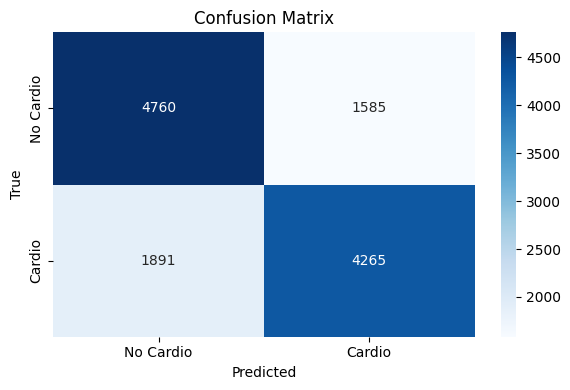

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cardio', 'Cardio'], yticklabels=['No Cardio', 'Cardio'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

ROC

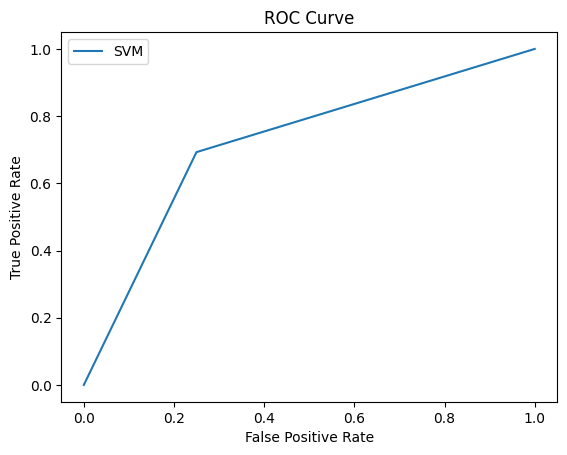

In [91]:
from sklearn.metrics import roc_curve, auc
fpr4,tpr4,thresholds4 = roc_curve(y_test, y_pred)
plt.plot(fpr4, tpr4, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# XAI techniques

In [18]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0c8e763c7e362c3cc6c9b9a963f6e36e2a6c410527c4df3c9caf241f656faa07
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Lime

In [79]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['No Cardio', 'Cardio'], mode='classification')
exp = explainer.explain_instance(X_test.iloc[15].values, rbf_svm.predict_proba, num_features=9)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [80]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['No Cardio', 'Cardio'], mode='classification')
exp = explainer.explain_instance(X_test.iloc[0].values, rbf_svm.predict_proba, num_features=9)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


permutation feature importance

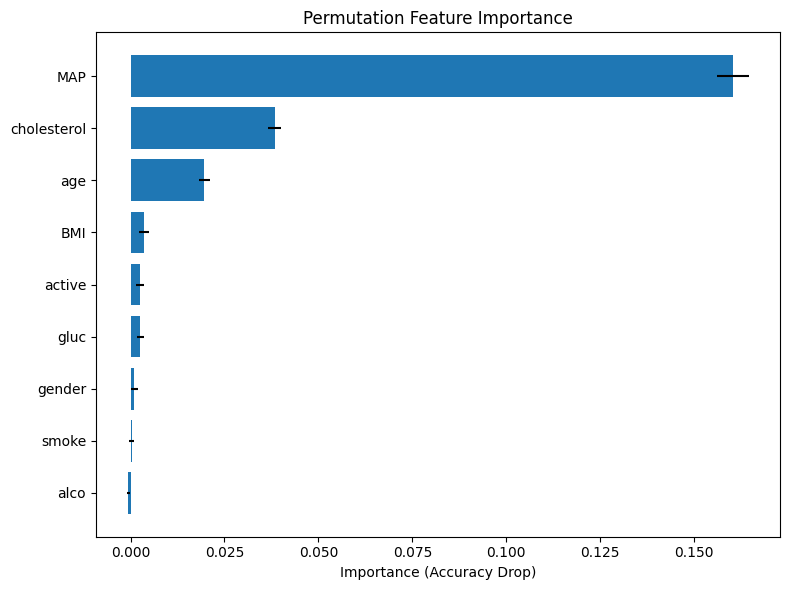

MAP: 0.1603 ± 0.0043
cholesterol: 0.0383 ± 0.0018
age: 0.0197 ± 0.0015
BMI: 0.0035 ± 0.0013
active: 0.0026 ± 0.0011
gluc: 0.0026 ± 0.0010
gender: 0.0010 ± 0.0009
smoke: 0.0003 ± 0.0006
alco: -0.0006 ± 0.0003


In [84]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rbf_svm,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), perm_importance.importances_mean[sorted_idx], xerr=perm_importance.importances_std[sorted_idx])
plt.yticks(range(len(features)), [features[i] for i in sorted_idx])
plt.xlabel('Importance (Accuracy Drop)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.savefig('permutation_importance.png')
plt.show()

for i in sorted_idx[::-1]:
    print(f"{features[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

PDP

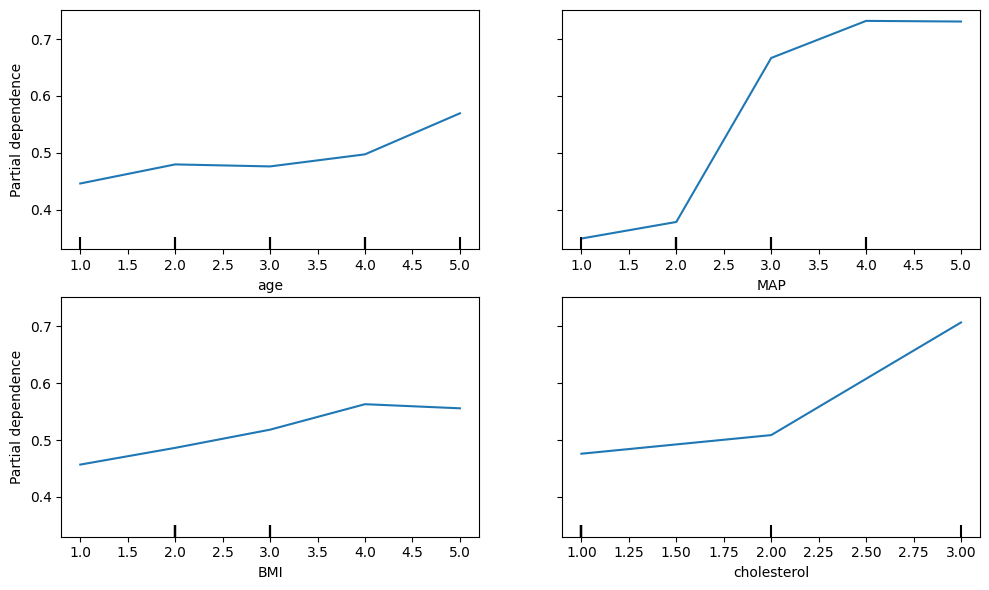

In [85]:
key_features = ['age', 'MAP', 'BMI', 'cholesterol']
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    rbf_svm,
    X_test,
    features=key_features,
    feature_names=features,
    target=1,
    kind='average',
    n_cols=2,
    ax=ax
)
plt.tight_layout()
plt.show()

ICE

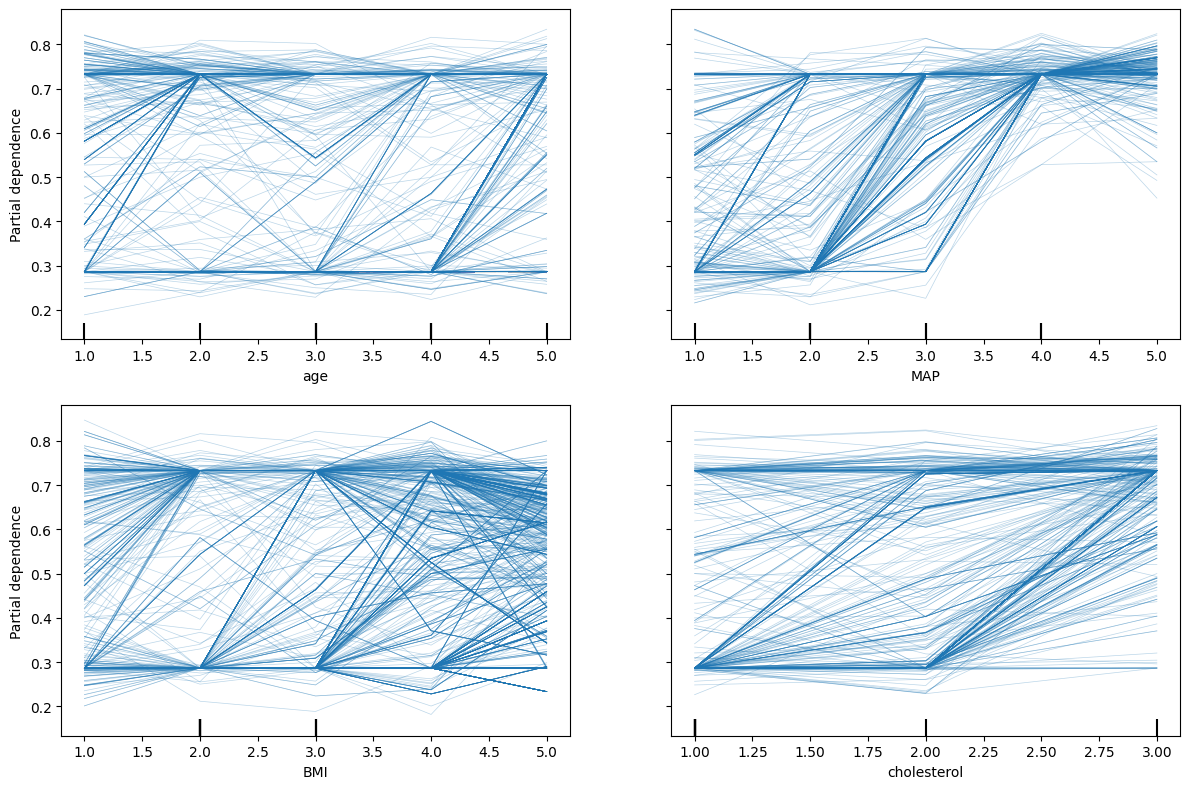

In [86]:
from sklearn.inspection import PartialDependenceDisplay
key_features = ['age', 'MAP', 'BMI', 'cholesterol']

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    rbf_svm,
    X_test[:2000],
    features=key_features,
    feature_names=features,
    kind='individual',
    target=1,
    n_cols=2,
    ax=ax
)
plt.tight_layout()
plt.show()